<a href="https://colab.research.google.com/github/Revanth-zeus/Hands-on-GAN/blob/main/Building_First_GAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Main ideology followed is to create the class of Each GAN by building blocks and to ensure that each block is working properly

In [29]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

The "sequential " helps to form the building blocks inside the generator_one class

In [30]:
def generator_one(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )


"ASSERT" is used to define if the situation is true or false


In [31]:
def generator_one_test(input_features,output_features,num_test=3):
  test_block=generator_one(input_features,output_features)
  assert len(test_block) == 3
  assert type(test_block[0]) ==nn.Linear
  assert type(test_block[1]) ==nn.BatchNorm1d
  assert type(test_block[2]) ==nn.ReLU

  test_input=torch.randn(num_test,input_features)
  test_output=test_block(test_input)
  assert test_output.shape==(num_test,output_features)
  return test_output



In [32]:
print(generator_one_test(512,1024))

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.4062, 1.2586, 0.0000],
        [0.6393, 1.2542, 1.2928,  ..., 0.0000, 0.0000, 1.3822],
        [0.7728, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)


In [33]:
class Generator(nn.Module):
    def __init__(self, z_samples_noise_vector=10, img_dimension=784, hidden_layer_dimension=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_one(z_samples_noise_vector, hidden_layer_dimension),
            generator_one(hidden_layer_dimension, hidden_layer_dimension * 2),
            generator_one(hidden_layer_dimension * 2, hidden_layer_dimension * 4),
            generator_one(hidden_layer_dimension * 4, hidden_layer_dimension * 8),
            nn.Linear(hidden_layer_dimension * 8, img_dimension),
            nn.Sigmoid()
        )

    def forward(self, noise):
      return self.gen(noise)

    def get_gen(self):
        return self.gen

In [34]:
# Example usage
z_samples = torch.randn(5, 10)  # Random noise vector of 5 samples, each with 10 dimensions
generator = Generator(z_samples_noise_vector=10, img_dimension=784)
generated_images = generator(z_samples)
print(generated_images.shape)  # Should print: torch.Size([5, 784])


torch.Size([5, 784])


In [35]:
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()
    assert len(gen) == 6, "Generator should have exactly 6 layers"
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)
    assert tuple(test_output.shape) == (num_test, im_dim), f"Expected output shape ({num_test}, {im_dim}), but got {test_output.shape}"
    assert test_output.max() <= 1, "Output values should be in the range [0, 1] after sigmoid activation"
    assert test_output.min() >= 0, "Output values should be in the range [0, 1] after sigmoid activation"
    assert 0.05 < test_output.std() < 0.15, f"Expected std between 0.05 and 0.15, but got {test_output.std()}"

# Test cases with realistic values
test_generator(10, 784, 128)  # Standard z_dim, im_dim, hidden_dim for MNIST-style generator
test_generator(100, 784, 128)  # Test with a larger noise vector (z_dim)
test_generator(10, 784, 256)  # Test with larger hidden dimension

print("Success!")


Success!


In [36]:
def test_own_generator(z_samples_noise_vector, img_dimension, hidden_layer_dimension,num_test=3):
  gen_test=Generator(z_samples_noise_vector,img_dimension,hidden_layer_dimension)
  assert len(gen_test.get_gen())==6
  test_own_input=torch.randn(num_test,z_samples_noise_vector)
  test_own_output=gen_test.get_gen()(test_own_input)
  assert test_own_output.shape==(num_test,img_dimension)
  print("excellent ")

test_own_generator(15,17,128)

excellent 


**GENERATING NOISE**

In [37]:
def noise_generation(num_samples,z_samples_noise_vector,device='cpu'):
  return torch.randn(num_samples,z_samples_noise_vector,device=device)
  print("excellent")

noise_generation(2,5)

tensor([[-0.0029, -0.6079, -0.4270, -0.5158,  0.2514],
        [ 0.2405,  2.0934, -0.0604,  0.1784, -0.1186]])

In [38]:
def test_noise_generation(num_samples, z_samples_noise_vector):
    test_two = noise_generation(num_samples, z_samples_noise_vector)
    assert test_two.shape == (num_samples, z_samples_noise_vector), f"Expected shape ({num_samples}, {z_samples_noise_vector}), but got {test_two.shape}"
    print("success")
test_noise_generation(2, 3)


success


**BUILDING DISCRIMINATOR**

In [39]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)
    )


In [40]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


In [41]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc


In [42]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
  disc = Discriminator(z_dim, hidden_dim).get_disc()
  assert len(disc) == 4
  test_input = torch.randn(num_test, z_dim)
  test_output = disc(test_input)
  assert tuple(test_output.shape) == (num_test, 1)
  assert not isinstance(disc[-1], nn.Sequential)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


**LOADING DATASET**

BCEwithLogitsloss : turns the output of discriminator(logits) into the range between 0 and 1 and gets the difference between the predicted label and the true label

In [43]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_samples_noise_vector = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cpu'

In [44]:
gen=Generator(z_samples_noise_vector).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc=Discriminator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr)


In [56]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_samples_noise_vector, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
                   the discriminator's predictions to the ground truth reality of the images
                   (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce,
                    which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #### START CODE HERE ####
    # Step 1: Generate noise vectors and fake images
    noise = torch.randn(num_images, z_samples_noise_vector, device=device)
    fake_images = gen(noise)

    # Step 2: Get discriminator predictions for fake images
    fake_preds = disc(fake_images.detach())
    fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))

    # Step 3: Get discriminator predictions for real images
    real_preds = disc(real)
    real_loss = criterion(real_preds, torch.ones_like(real_preds))

    # Step 4: Combine the losses
    disc_loss = (real_loss + fake_loss) / 2
    #### END CODE HERE ####

    return disc_loss


In [46]:
torch_usage1= torch.zeros(5)
print(torch_usage1)

tensor([0., 0., 0., 0., 0.])


In [47]:
torch_usage1= torch.ones(5)
print(torch_usage1)

tensor([1., 1., 1., 1., 1.])


the .detach() is used to stop calculating the gradients

In [57]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = torch.randn(num_images, z_samples_noise_vector, device=device)
    fake_images = gen(noise)
    disc_preds = disc(fake_images)
    true_labels = torch.ones_like(disc_preds, device=device)
    gen_loss = criterion(disc_preds, true_labels)
    return gen_loss


In [59]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None

    z_samples_noise_vector = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_samples_noise_vector)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_samples_noise_vector, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)

    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_samples_noise_vector)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_samples_noise_vector, 'cpu')) < 1e-5)

    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_samples_noise_vector, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_samples_noise_vector, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))

def test_disc_loss(max_tests = 10):
    z_samples_noise_vector = 64
    gen = Generator(z_samples_noise_vector).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_samples_noise_vector, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data

        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")


Success!


In [60]:
def get_gen_loss(gen, disc, criterion, num_images, z_samples_noise_vector, device):

    noise = torch.randn(num_images, z_samples_noise_vector, device=device)

    # 2) Generate a batch of fake images
    fake_images = gen(noise)

    # 3) Get the discriminator's predictions on the fake images
    disc_preds = disc(fake_images)

    true_labels = torch.ones_like(disc_preds, device=device)
    gen_loss = criterion(disc_preds, true_labels)
    #### END CODE HERE ####

    return gen_loss


In [62]:
def test_gen_reasonable(num_images=10):
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None

    z_samples_noise_vector = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_samples_noise_vector, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_samples_noise_vector)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_samples_noise_vector, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    assert tuple(gen_loss_tensor.shape) == (num_images, z_samples_noise_vector)


def test_gen_loss(num_images):
    z_samples_noise_vector = 64
    gen = Generator(z_samples_noise_vector).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_samples_noise_vector, device)


    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.6778015346527098, discriminator loss: 0.30704358845949165


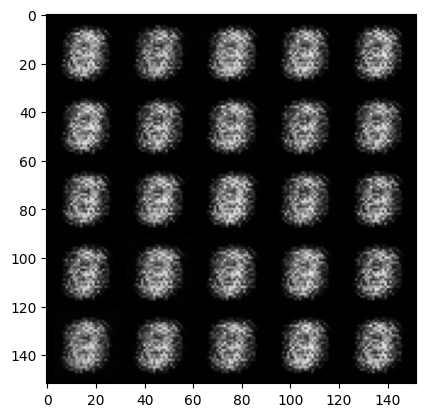

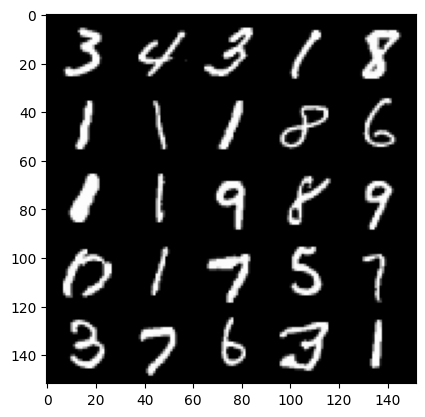

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.9511536550521855, discriminator loss: 0.17934472435712812


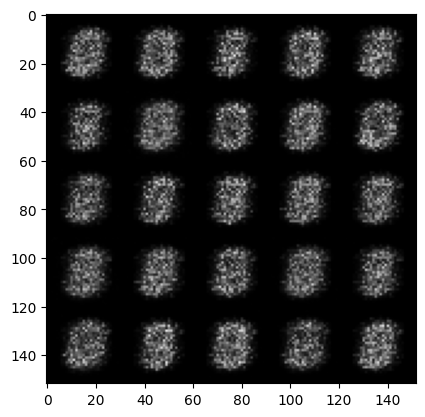

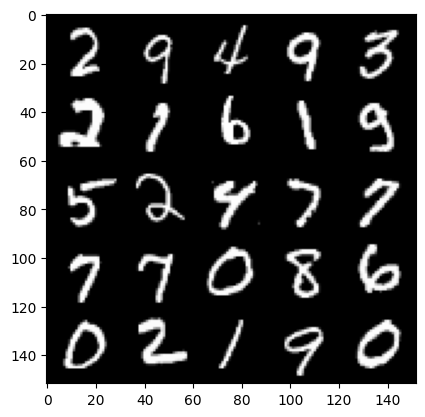

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.6641851255893727, discriminator loss: 0.22862640327215178


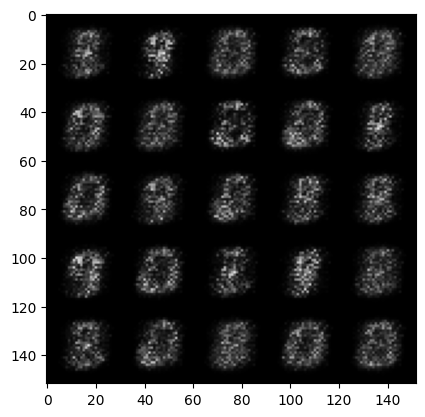

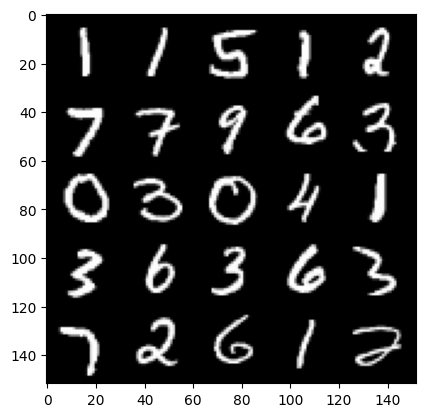

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.5414465253353125, discriminator loss: 0.23753409922122948


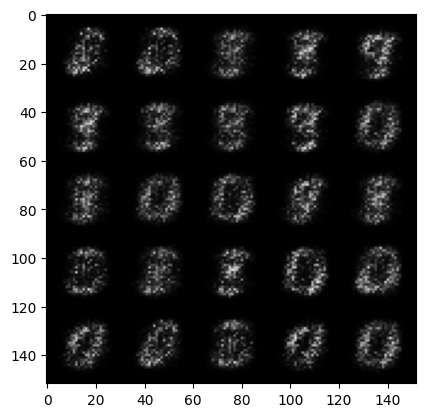

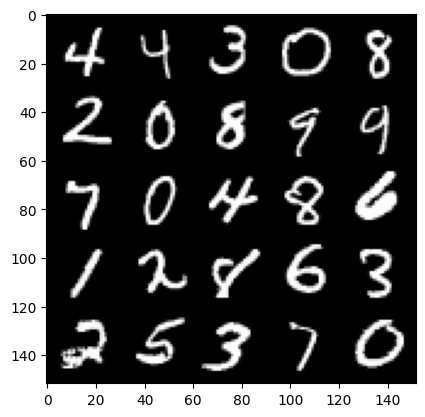

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.745599437713623, discriminator loss: 0.21220372885465613


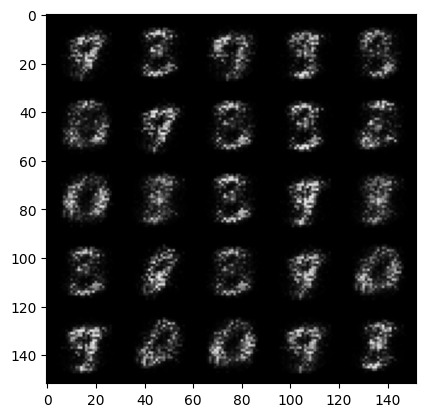

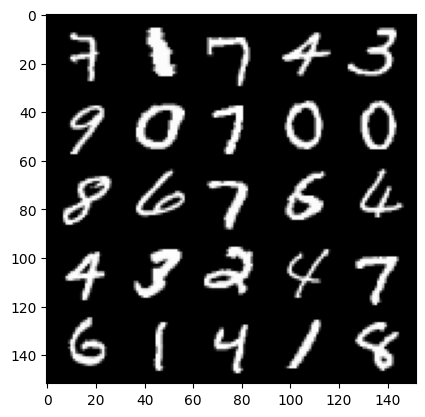

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.076087855815887, discriminator loss: 0.1805289404392239


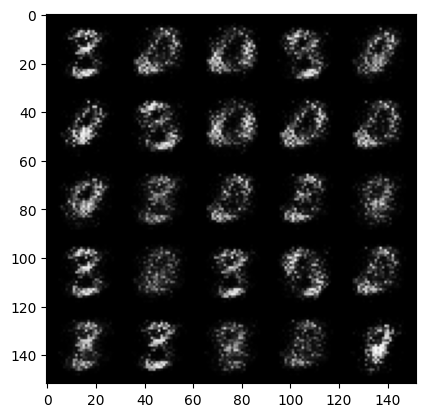

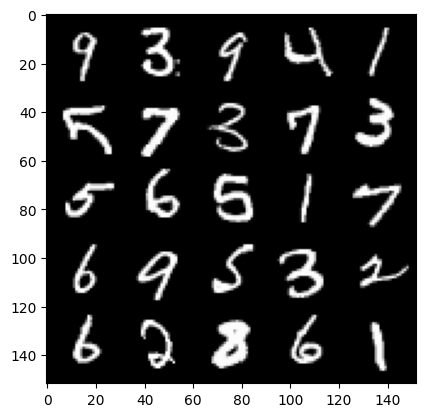

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
# OPTIONAL PART

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True  # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_samples_noise_vector, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        # 1) Zero out the gradients.
        gen_opt.zero_grad()

        # 2) Calculate the generator loss, assigning it to gen_loss.
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_samples_noise_vector, device)

        # 3) Backprop through the generator: update the gradients and optimizer.
        gen_loss.backward()

        # Update the optimizer for the generator
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = noise_generation(cur_batch_size, z_samples_noise_vector, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
